# Gesture Recognition Solution Using Deep Learning Models
In this project, we will build deep learnng models that will be able to recognise 5 different hand gestures correctly.

## Problem Statement
We want to develop a cool feature in the smart-TV for the TV Manufacturers that can recognise **five different gestures** performed by the user which will help users control the TV without using a remote. The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

* Thumbs up:  Increase the volume
* Thumbs down: Decrease the volume
* Left swipe: 'Jump' backwards 10 seconds
* Right swipe: 'Jump' forward 10 seconds  
* Stop: Pause the movie

The training data consists of a few hundred videos categorised into one of the five classes corresponding to five gestures. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

Our task is to train a deep learning model using the gesture clips in the 'train' folder which performs well on the clips in the 'val' folder as well.

## Approach
Our approach for analysing videos using neural networks would include exploring two types of architectures:
1. **3D convolutional network** which is a natural extension to the 2D convolutions in which case, the input to a 3D conv is a video (which is a sequence of 30 RGB images). The video becomes a 4-D tensor of shape 100x100x3x30. A 3-D kernel/filter (a 'cubic' filter) will '3D-convolve' on each of the three channels of the (100x100x30) tensor.
2. **Standard CNN + RNN architecture** in which we pass the images of a video through a Convolutional Neural Network (CNN) which extracts a feature vector for each image, and then pass the sequence of these feature vectors through a Recurrent Neural Network(RNN).

The **Steps** we will take in this project are:

1. Setup Data Access
2. Build Generator for Incremental Image Loading
3. Build and Validate Models
4. Conclusion

## 1. Setup Data Access

In [17]:
# !pip install imageio pillow
# !pip install h5py

In [18]:
import numpy as np
import os
import math
import imageio.v2 as imageio
from PIL import Image
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [19]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [20]:
# Mount Gdrive in case Google Colab is used for GPU processing

## Mount gdrive and read dataset from gdrive
# from google.colab import drive
# drive.mount('/content/drive')

# base_path = '/content/drive/My Drive/Learn/AI-ML/Upgrad/GestureRecognition/Project_data'

In [21]:
# Set the base path to video data
base_path = '/home/datasets/Project_data'    # For Jarvislabs Platform
# base_path = '/content/drive/MyDrive/DS Datasets/Project_data'    # For Google Colab Platform
# base_path = '/notebooks/storage/Final_data/Collated_training'    # For Local PC
# base_path = '/Users/achindas/Library/CloudStorage/OneDrive-Personal/Current Office/Career - 2024/EGP in ML & AI - IIITB/Course 4 - Deep Learning/Mod 7 - Gesture Recog Project/Project_data'   # For Local PC

# Read the folder lists containing video images for different gesture types related to training and validation
train_doc = np.random.permutation(open(f'{base_path}/train.csv').readlines())
val_doc = np.random.permutation(open(f'{base_path}/val.csv').readlines())


In [22]:
batch_size = 32

## 2. Build Generator for Incremental Image Loading
In this deep learning project, we need to feed data to the model in batches. This is done using the concept of generators.

In the generator, we are going to preprocess the images as we have images of 2 different dimensions (120 X 160 and 360 X 360) as well as create a batch of video frames. We will have to experiment with `img_idx`, `image height`,`image width` and normalization to arrive at high accuracy. We will create two Generators - one with **data augmentation** and other with only cropping and resizing

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the generator method with additional image augmentation.
# This method will be used for Conv3D models to reduce overfitting
def generator(source_path, folder_list, batch_size, img_idx, img_h, img_w):
    print('\nSource path =', source_path, '; batch size =', batch_size)
    datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=10,
        brightness_range=[0.8,1.2]
    )
    while True:
        t = np.random.permutation(folder_list)
        num_batches = math.ceil(len(folder_list)/batch_size)
        for batch in range(num_batches):
            current_batch_size = min(batch_size, len(folder_list) - batch * batch_size)
            x = len(img_idx)
            y = img_h
            z = img_w
            batch_data = np.zeros((current_batch_size, x, y, z, 3))
            batch_labels = np.zeros((current_batch_size, 5))
            for folder in range(current_batch_size):
                folder_name = t[batch * batch_size + folder].strip().split(';')[0]
                label = int(t[batch * batch_size + folder].strip().split(';')[2])
                imgs = sorted(os.listdir(os.path.join(source_path, folder_name)))
                for idx, item in enumerate(img_idx):
                    if item >= len(imgs):
                        # Loop back if index exceeds the number of images
                        item = item % len(imgs)
                    image_path = os.path.join(source_path, folder_name, imgs[item])
                    image = imageio.imread(image_path)
                    # Resize while maintaining aspect ratio
                    image_pil = Image.fromarray(image)
                    image_pil.thumbnail((img_w, img_h), Image.LANCZOS)
                    # Center crop
                    left = (image_pil.width - img_w)/2
                    top = (image_pil.height - img_h)/2
                    right = (image_pil.width + img_w)/2
                    bottom = (image_pil.height + img_h)/2
                    image_pil = image_pil.crop((left, top, right, bottom))
                    image_array = np.array(image_pil).astype(np.float32)
                    # Apply data augmentation
                    image_array = datagen.random_transform(image_array)
                    # Assign image to batch data
                    batch_data[folder, idx] = image_array
                batch_labels[folder, label] = 1
            yield batch_data, batch_labels

# Define the generator method without image augmentation.
# This method will be used for CNN+RNN models
def generator2(source_path, folder_list, batch_size, img_idx, img_h, img_w):
    print('\nSource path =', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = math.ceil(len(folder_list)/batch_size) # num_batches will be 1 extra for last fractional batch
        for batch in range(num_batches):  # iterate over number of batches
            if batch == num_batches-1:   # Handle the last batch specially in case it's fractional batch
                current_batch_size = len(folder_list) -  batch * batch_size # find remaining videos to process
            else:
                current_batch_size = batch_size
            # print('\nBatch No =', batch, '; Current batch size =', current_batch_size)
            x = len(img_idx)
            y = img_h
            z = img_w
            batch_data = np.zeros((current_batch_size, x, y, z, 3))  # Create batch data array
            batch_labels = np.zeros((current_batch_size, 5))  # Create batch labels array

            for folder in range(current_batch_size):  # iterate over batch_size
                imgs = os.listdir(os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0]))  # Read images in folder
                for idx, item in enumerate(img_idx):  # Iterate over frames/images in folder
                    image_path = os.path.join(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])

                    # Load, crop and resize image to img_h X img_w, keeping in memory
                    image = imageio.imread(image_path)

                    # Crop non-symmetric images of shape (120, 160) to (120, 120)
                    height, width, channel = image.shape
                    if width == 160:
                        image=image[:120,20:140,:]

                    image_pil = Image.fromarray(image)
                    image_resized = image_pil.resize((img_h, img_w), Image.LANCZOS) # Image.ANTIALIAS is deprecated
                    image_array = np.array(image_resized).astype(np.float32)

                    # Normalize and assign resized image to batch_data
                    batch_data[folder, idx, :, :, 0] = image_array[:, :, 0] / 255.0
                    batch_data[folder, idx, :, :, 1] = image_array[:, :, 1] / 255.0
                    batch_data[folder, idx, :, :, 2] = image_array[:, :, 2] / 255.0

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels  # Yield the batch data and labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). This will be taken this into consideration while creating the model architecture.

In [24]:
curr_dt_time = datetime.datetime.now()
train_path = f'{base_path}/train'
val_path = f'{base_path}/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## 3. Build and Validate Models
Here we make the models using different functionalities that Keras provides. We need to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would use `TimeDistributed` while building a Conv2D + RNN model. The last layer is the softmax. We need to design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### 3.1 Create Common Utility Functions

In [25]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, LSTM
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Dropout, Bidirectional, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

In [26]:
# Build some generic utility functions that can be used for model building

# Python function to compile and summarise models
def model_compile(model,optimiser):
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model.summary()

# Python function to train models
def model_train(model, model_abbr, train_generator, steps_per_epoch, num_epochs,val_generator,validation_steps, curr_dt_time):
    model_name = 'model_'+ model_abbr +'_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    csv_logger = CSVLogger(model_name + 'training.log')   # This callback is for saving training history

    callbacks_list = [checkpoint, LR, csv_logger]

    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)
    return history

# Function to plot training & validation metrics
def model_plot(history, epochs):
    # Extract the accouracy and loss results from Model result
    trg_acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    trg_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 6))

    # Plot the Accuracy trend
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, trg_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot the Loss trend
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, trg_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Instantiate the Train and Validation image Generators to be used by model.fit() method

def train_conv3d_model(model, callbacks_list):
    train_generator = generator(train_path, train_doc, batch_size, img_idx, img_h, img_w)
    val_generator = generator(val_path, val_doc, batch_size, img_idx, img_h, img_w)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    #Train Model
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)
    return history

# Create and return the Callbacks for model training
def get_conv3d_callbacks():
    # Set-up for saving model execution weights
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=False,
                                 save_weights_only=False,
                                 mode='auto')

    LR = ReduceLROnPlateau(
        monitor='val_loss',     # Monitor the validation loss
        factor=0.1,             # Reduce the learning rate by a factor of 0.1 (new_lr = old_lr * factor)
        patience=5,            # Number of epochs with no improvement after which the learning rate will be reduced
        min_lr=1e-6,            # Minimum learning rate that the model will reduce to
        verbose=1               # Print messages when learning rate is reduced
    )
    callbacks_list = [checkpoint, LR]
    return callbacks_list

In [27]:
# Set the image size as (img_h, img_w). Also set the index for the iamges/ frames to be used within a video
img_h, img_w = 128, 128
img_idx = [x for x in range(0, 30, 2)] # Alternate images index
frames_cnt = len(img_idx)   # Number of frames per video to be considered for training

In [28]:
# Instantiate the Train and Validation image Generators to be used by model.fit() method

# Define the Generators to be used by CNN+RNN models which does not use the image augmentation function
# For Conv3D models, Generators have been defined for each model
train_generator = generator2(train_path, train_doc, batch_size, img_idx, img_h, img_w)
val_generator = generator2(val_path, val_doc, batch_size, img_idx, img_h, img_w)

# Establish other parameters for model.fit() method
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### 3.2 Build & Experiment with Conv3D Architecture
In this section we will experiment with Conv3D models by changing various parameters and select the best Conv3D model

#### 3.2.1 Conv3D 3-Layer Model
Create a basic Conv3D model with three Conv3D layers

In [79]:
# 3-Conv3D layers and Image size 128 X 128

#Init default values
num_epochs = None
batch_size = None

img_h, img_w = None, None
img_idx = None
frames_cnt = None
input_shape = None
kernel_size = None

# Set key parameters
def init_hyper_params():
    global num_epochs, batch_size, img_h, img_w, img_idx, frames_cnt, input_shape, kernel_size
    num_epochs = 50
    batch_size = 32

    img_h, img_w = 128, 128
    img_idx = [x for x in range(0, 30, 2)] # Alternate images index
    frames_cnt = len(img_idx)
    input_shape = (frames_cnt, img_h, img_w, 3)
    kernel_size = (3,3,3)

# Define the model
def create_conv3d_model_1():
    model = Sequential(
        [
            Conv3D(filters=32, kernel_size=kernel_size, padding='same', activation='relu', input_shape=input_shape),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=64, kernel_size=kernel_size, padding='same',  activation='relu'),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=128, kernel_size=kernel_size, padding='same',  activation='relu'),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Flatten(),
            #Dense layer
            Dense(units=128, activation='relu'),
            Dense(units=5, activation='softmax')
        ]
    )
    return model




init_hyper_params()
model = create_conv3d_model_1()

# Compile the model
optimiser = Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_compile(model, optimiser))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 15, 128, 128, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 7, 64, 64, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 7, 64, 64, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 3, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 3, 32, 32, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 1, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,474,373 (17.07 MB)

 Trainable params: 4,474,373 (17.07 MB)

 Non-trainable params: 0 (0.00 B)

None


In [80]:

callback_list = get_conv3d_callbacks()
history = train_conv3d_model(model, callback_list)

#Plot accuracy -loss graph
model_plot(history, num_epochs)


Source path = /content/drive/My Drive/Learn/AI-ML/Upgrad/GestureRecognition/Project_data/train ; batch size = 32


KeyboardInterrupt: 

#### **Observations:**
The model underfits with training and validation accuracies at 0.53 and 0.47 respectively

#### 3.2.2 Conv3D 4-Layer Base Model
Add another 4th Conv3D layer to the basic model

In [ ]:
# 4-Conv3D layers and Image size 128 x 128

# Set key parameters
def int_hyper_params_conv3d_model2():
    global num_epochs, batch_size, img_h, img_w, img_idx, frames_cnt, input_shape, kernel_size
    batch_size = 32
    num_epochs = 50

    img_h, img_w = 128, 128
    img_idx = [x for x in range(30)]
    frames_cnt = len(img_idx)
    input_shape = (frames_cnt, img_h, img_w, 3)
    kernel_size = (3,3,3)

# Define the model
def create_conv3d_model2():
    model_2 = Sequential(
        [
            Conv3D(filters=32, kernel_size=kernel_size, padding='same', activation='relu', input_shape=input_shape),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=64, kernel_size=kernel_size, padding='same',  activation='relu'),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=128, kernel_size=kernel_size, padding='same',  activation='relu'),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=256, kernel_size=kernel_size, padding='same',  activation='relu'),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Flatten(),
            #Dense layers
            Dense(units=256, activation='relu'),
            Dense(units=128, activation='relu'),
            Dense(units=5, activation='softmax')
        ]
    )
    return model_2

#Initialize hyper parameters
int_hyper_params_conv3d_model2()
#Create model
model  = create_conv3d_model2()
# Compile the model
optimiser = Adam(learning_rate=0.001) # model was not converging in the previous step bz of learning rate .0001
print (model_compile(model, optimiser))



In [ ]:
callback_list = get_conv3d_callbacks()
history = train_conv3d_model(model, callback_list)

#Plot accuracy -loss graph
model_plot(history, num_epochs)

#### **Observations:**
Model overfitting - Training accuracy : 0.98, Validation Accuracy : 0.65

#### 3.2.3 Conv3D 4-Layer Model with Dropouts

Add Dropout layers (0.2) after Dense layers to prevent overfitting.

In [ ]:
# 4-Conv3D layers and Image size 128 x 128

# Set key parameters
def int_hyper_params_conv3d_model3():
    global num_epochs, batch_size, img_h, img_w, img_idx, frames_cnt, input_shape, kernel_size
    batch_size = 32
    num_epochs = 50

    img_h, img_w = 128, 128
    img_idx = [x for x in range(30)]
    frames_cnt = len(img_idx)
    input_shape = (frames_cnt, img_h, img_w, 3)
    kernel_size = (3,3,3)

# Define the model
def create_conv3d_model3():
    model_3 = Sequential(
        [

            Conv3D(filters=32, kernel_size=kernel_size, padding='same', activation='relu', input_shape=input_shape),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=64, kernel_size=kernel_size, padding='same',  activation='relu'),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=128, kernel_size=kernel_size, padding='same',  activation='relu'),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=256, kernel_size=kernel_size, padding='same',  activation='relu'),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Flatten(),
            #Dense layers
            Dense(units=256, activation='relu'),
            Dropout(0.2),
            Dense(units=128, activation='relu'),
            Dropout(0.2),
            Dense(units=5, activation='softmax')
        ]
    )
    return model_3

# Compile the model
int_hyper_params_conv3d_model3()
model = create_conv3d_model3()
optimiser = Adam(learning_rate=0.001) # model was not converging in the previous step bz of learning rate .0001
print (model_compile(model, optimiser))


In [ ]:
callback_list = get_conv3d_callbacks()
history = train_conv3d_model(model, callback_list)

#Plot accuracy -loss graph
model_plot(history, num_epochs)

#### **Observations:**
Model training accuracy got reduced by adding Dropout layer - Training accuracy : 0.69
Validation Accuracy : 0.58

#### 3.2.4 Conv3D 4-Layer Model with Batch Normalisation

Add Batch Normalisation in each Conv3D layer to improve training speed and stability

In [ ]:
# 4 Conv3D layers and normalization

# Set key parameters
def int_hyper_params_conv3d_model4():
    global num_epochs, batch_size, img_h, img_w, img_idx, frames_cnt, input_shape, kernel_size
    batch_size = 16
    num_epochs = 30

    img_h, img_w = 112, 112
    img_idx = [x for x in range(0, 30, 2)]
    frames_cnt = len(img_idx)
    input_shape = (frames_cnt, img_h, img_w, 3)
    kernel_size = (3,3,3)

# Define the model
def create_conv3d_model4():
    model_4 = Sequential([
        Conv3D(filters=64, kernel_size=kernel_size, padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid'),  # Pool only spatial dimensions

        Conv3D(filters=128, kernel_size=kernel_size, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), padding='valid'),

        Conv3D(filters=256, kernel_size=kernel_size, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(1, 2, 2), strides=(2, 2, 2), padding='valid'),

        Conv3D(filters=512, kernel_size=kernel_size, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid'),  # Pool only spatial dimensions

        Flatten(),
        Dense(units=512, activation='relu'),
        Dropout(0.5),
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=5, activation='softmax')
    ])
    return model_4


int_hyper_params_conv3d_model4()
model = create_conv3d_model4()

# Compile the model
optimiser = Adam(learning_rate=0.0001)
print (model_compile(model, optimiser))

In [ ]:
callback_list = get_conv3d_callbacks()
history = train_conv3d_model(model, callback_list)

#Plot accuracy -loss graph
model_plot(history, num_epochs)

#### **Observations:**
Model training accuracy got reduced further by increasing the filter count -  Training accuracy : 0.60
Validation Accuracy : 0.49

#### 3.2.5 Conv3D 4-Layer Model with L2 Regularisation

Add L2 Regularisers to each Conv3D layer to penalise large weights to prevent overfitting

In [ ]:
# Updated parameters

# Set key parameters
def int_hyper_params_conv3d_model5():
    global num_epochs, batch_size, img_h, img_w, img_idx, frames_cnt, input_shape, kernel_size
    batch_size = 32
    num_epochs = 50

    img_h, img_w = 128, 128
    img_idx = [x for x in range(30)]
    frames_cnt = len(img_idx)
    input_shape = (frames_cnt, img_h, img_w, 3)
    kernel_size = (3,3,3)


def create_conv3d_model5():
    # Define weight regularizer
    weight_regularizer = regularizers.l2(0.0005)

    # Define the model
    model_5 = Sequential([

            Conv3D(filters=32, kernel_size=kernel_size, padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=weight_regularizer),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=64, kernel_size=kernel_size, padding='same',  activation='relu', kernel_regularizer=weight_regularizer),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=128, kernel_size=kernel_size, padding='same',  activation='relu', kernel_regularizer=weight_regularizer),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=256, kernel_size=kernel_size, padding='same',  activation='relu', kernel_regularizer=weight_regularizer),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Flatten(),
            #Dense layers
            Dense(units=256, activation='relu'),
            BatchNormalization(),
            Dropout(0.4),
            BatchNormalization(),
            Dense(units=128, activation='relu'),
            BatchNormalization(),
            Dropout(0.4),
            Dense(units=5, activation='softmax')

    ])
    return model_5


int_hyper_params_conv3d_model5()
model = create_conv3d_model5()

# Compile the model
optimiser = Adam(learning_rate=0.0001)
print (model_compile(model, optimiser))



In [ ]:
#Add Early stopping to save training time
def get_conv3d_model_5_callback(early_stop_patience = 5):

    # Set-up for saving model execution weights
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

    # Callbacks
    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto')

    LR = ReduceLROnPlateau(
        monitor='val_loss',     # Monitor the validation loss
        factor=0.1,             # Reduce the learning rate by a factor of 0.1 (new_lr = old_lr * factor)
        patience=5,            # Number of epochs with no improvement after which the learning rate will be reduced
        min_lr=1e-6,            # Minimum learning rate that the model will reduce to
        verbose=1               # Print messages when learning rate is reduced
    )
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop_patience, restore_best_weights=True)
    callbacks_list = [checkpoint, LR, early_stopping]
    return callbacks_list

callbacks_list = get_conv3d_model_5_callback()
history = train_conv3d_model(model, callback_list)

#Plot accuracy -loss graph
model_plot(history, num_epochs)

#### **Observations:**
Accuracy and consistency of the model increased by adding Batchnormalisation and l2 regulariser in conv3d layer - Training accuracy : 0.80
Validation Accuracy : 0.84

#### 3.2.6 Conv3D 4-Layer Model with Increased Dropouts

Increase Dropout to 0.5 for stronger overfit prevention

In [ ]:

def create_conv3d_model6():

    # Define weight regularizer
    weight_regularizer = regularizers.l2(0.0005)

    # Define the model
    model_6 = Sequential([

            Conv3D(filters=32, kernel_size=kernel_size, padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=weight_regularizer),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=64, kernel_size=kernel_size, padding='same',  activation='relu', kernel_regularizer=weight_regularizer),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=128, kernel_size=kernel_size, padding='same',  activation='relu', kernel_regularizer=weight_regularizer),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Conv3D(filters=256, kernel_size=kernel_size, padding='same',  activation='relu', kernel_regularizer=weight_regularizer),
            BatchNormalization(),
            MaxPooling3D(pool_size=(2, 2, 2)),
            Flatten(),
            #Dense layers
            Dense(units=256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            BatchNormalization(),
            Dense(units=128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(units=5, activation='softmax')

    ])
    return model_6


#using the same hyperparameters of Model-5
model = create_conv3d_model6()

# Compile the model
optimiser = Adam(learning_rate=0.0001)
print (model_compile(model, optimiser))


In [ ]:
#Using the same callbacks as Model 5
callbacks_list = get_conv3d_model_5_callback(10)
history = train_conv3d_model(model, callback_list)

#Plot accuracy -loss graph
model_plot(history, num_epochs)

#### **Observations:**
Increasing the Dropout to .5 reduced the model accuracy - Training accuracy : 0.65
Validation Accuracy : 0.60


### 3.3 Build & Experiment with CNN+RNN Architecture

In this section we will experiment with CNN+RNN models by changing various parameters and select the best CNN+RNN model

In [30]:
# Reset the image size as (img_h, img_w). Also set the index for the iamges/ frames to be used within a video
img_h, img_w = 64, 64
img_idx = [x for x in range(0, 30, 2)] # Alternate images index
frames_cnt = len(img_idx)   # Number of frames per video to be considered for training

# Reset the execution parameters
batch_size = 32
num_epochs = 20

In [31]:
# Instantiate the Train and Validation image Generators to be used by model.fit() method

# Define the Generators to be used by CNN+RNN models which does not use the image augmentation function
train_generator = generator2(train_path, train_doc, batch_size, img_idx, img_h, img_w)
val_generator = generator2(val_path, val_doc, batch_size, img_idx, img_h, img_w)

# Establish other parameters for model.fit() method
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### 3.3.1 Basic CNN-GRU Model

Create a 3-layer Conv2D CNN model and feed it to a RNN with GRU gate

In [20]:
# Define a 3-Layer Conv2D CNN+RNN Model with GRU gate

input_shape = (img_h, img_w, 3)

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
cnn.add(Activation('relu'))

cnn.add(Conv2D(64, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(128, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))

# Create the GRU RNN model and add CNN model to it
input_shape = (frames_cnt, img_h, img_w, 3)

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=input_shape))
model.add(GRU(64))
model.add(Dense(5, activation='softmax'))

2024-11-11 08:14:37.127785: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-11 08:14:37.127849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 64)           2190464   
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2,215,749
Trainable params: 2,215,749
Non-trainable params: 0
_________________________________________________________________
None

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/5


2024-11-11 08:14:41.665477: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.6286 - categorical_accuracy: 0.1961
Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.55956, saving model to model_basic_cnn_gru_2024-11-1108_14_37.400925/model-00001-1.62857-0.19608-1.55956-0.18000.keras
21/21 [==============================] - 44s 2s/step - loss: 1.6286 - categorical_accuracy: 0.1961 - val_loss: 1.5596 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 1.4890 - categorical_accuracy: 0.3318
Epoch 00002: val_loss improved from 1.55956 to 1.44765, saving model to model_basic_cnn_gru_2024-11-1108_14_37.400925/model-00002-1.48903-0.33183-1.44765-0.27000.keras
21/21 [==============================] - 39s 2s/step - loss: 1.4890 - categorical_accuracy: 0.3318 - val_loss: 1.4476 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 1.26

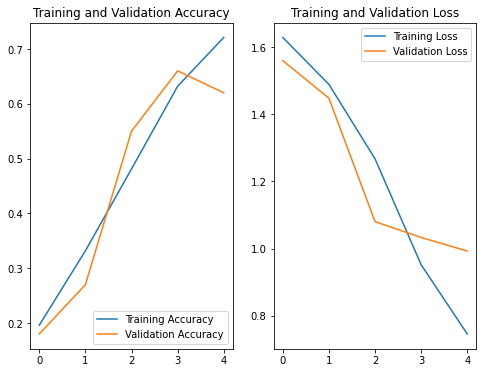

In [21]:
# Execute the model
curr_dt_time = datetime.datetime.now() # datetimestamp to be appended to model save file

# Reset the Generators to be used by CNN+RNN model
train_generator = generator2(train_path, train_doc, batch_size, img_idx, img_h, img_w)
val_generator = generator2(val_path, val_doc, batch_size, img_idx, img_h, img_w)

# Compile the model and print summary
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
print(model_compile(model, optimiser))

# Train the model
hist = model_train(model, 'basic_cnn_gru', train_generator, steps_per_epoch, num_epochs, val_generator, validation_steps, curr_dt_time)

# Visualise the model performance
model_plot(hist, num_epochs)

#### **Observations:**
There is high bias in the model evident thru’ low accuracies. We need to increase the Conv2D layers for better feature extraction and GRU units for higher temporal accuracy. Also reduce image size to accelerate the training time and check the effect on overfitting.

#### 3.3.2 CNN-GRU Model with Batch Normalisation

Add Drop-out after GRU layer & batch normalisation to basic CNN-RNN model

In [32]:
# Add Drop-out after GRU layer & batch normalisation to basic CNN-RNN model

input_shape = (img_h, img_w, 3)

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
cnn.add(Activation('relu'))
cnn.add(BatchNormalization())

cnn.add(Conv2D(64, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())

cnn.add(Conv2D(128, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())

# cnn.add(Flatten())
# cnn.add(Dense(128, activation='relu'))
cnn.add(GlobalAveragePooling2D())

# Create TimeDistributed CNN for each frame
input_frames = (frames_cnt, img_h, img_w, 3)

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=input_frames))

# GRU Layer for Temporal Dependency
model.add(GRU(128, return_sequences=False)) # return sequence not required as only the final output is needed for classification

# Drop-out for regularisation
model.add(Dropout(.5))

# Dense Layer for Classification
model.add(Dense(5, activation='softmax'))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 15, 128)          94144     
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 193,861
Trainable params: 193,413
Non-trainable params: 448
_________________________________________________________________
None

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [======================

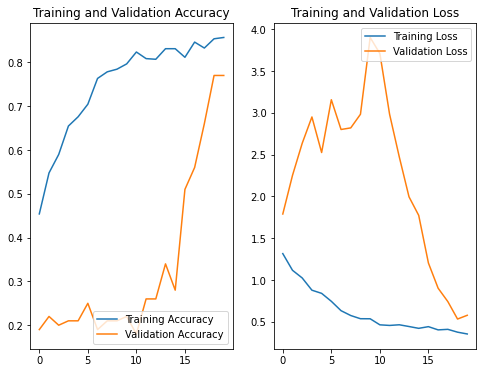

In [33]:
# Execute the model
curr_dt_time = datetime.datetime.now() # datetimestamp to be appended to model save file

# Reset the Generators to be used by CNN+RNN model
train_generator = generator2(train_path, train_doc, batch_size, img_idx, img_h, img_w)
val_generator = generator2(val_path, val_doc, batch_size, img_idx, img_h, img_w)

# Compile the model and print summary
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
print(model_compile(model, optimiser))

# Train the model
hist = model_train(model, 'basic_cnn_gru_reg', train_generator, steps_per_epoch, num_epochs, val_generator, validation_steps, curr_dt_time)

# Visualise the model performance
model_plot(hist, num_epochs)

#### **Observations:**
Overfitting slightly improved with increased validation accuracy. Trainable parameters reduced drastically with faster training speed.

#### 3.3.3 CNN-GRU Transfer Model

Use MobileNetV2 pre-trained CNN model which is light-weight for small mobile devices as the feature extractor

In [24]:
from tensorflow.keras.applications import MobileNetV2

# Parameters
input_shape = (frames_cnt, img_h, img_w, 3)  # 15 frames, img_h X img_w resolution, 3 channels (RGB)
num_classes = 5  # 5 different gestures to classify

# CNN Backbone for feature extraction from each frame
cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
cnn_base.trainable = False  # Freeze CNN layers to speed up training

# Create a TimeDistributed wrapper around CNN
input_frames = Input(shape=input_shape)
x = TimeDistributed(cnn_base)(input_frames)
x = TimeDistributed(GlobalAveragePooling2D())(x)  # Reduce spatial dimensions

# GRU Layer for Temporal Dependency
x = GRU(128, return_sequences=False)(x)  # 128 units in GRU layer

# Final Classification Layer
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input_frames, outputs=output)

9420800/9406464 [==============================] - 0s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 2, 2, 1280)   2257984   
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 1280)         0         
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 128)               541440    
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,800,069
Trainable params: 542,085
Non-trainab

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


21/21 [==============================] - 45s 2s/step - loss: 1.5331 - categorical_accuracy: 0.3484 - val_loss: 1.2224 - val_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 0.7367 - categorical_accuracy: 0.7541
Epoch 00002: val_loss improved from 1.22240 to 1.04497, saving model to model_basic_cnn_gru_trans_2024-11-1108_21_31.860469/model-00002-0.73675-0.75415-1.04497-0.59000.keras
21/21 [==============================] - 39s 2s/step - loss: 0.7367 - categorical_accuracy: 0.7541 - val_loss: 1.0450 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 0.4137 - categorical_accuracy: 0.9080
Epoch 00003: val_loss did not improve from 1.04497
21/21 [==============================] - 40s 2s/step - loss: 0.4137 - categorical_accuracy: 0.9080 - val_loss: 1.4213 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 4/5
21/21 [==============================] - ETA: 0s - loss: 

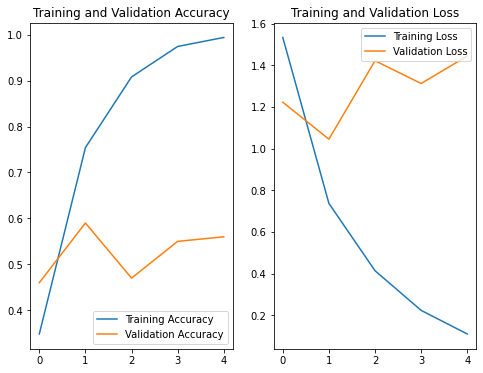

In [25]:
# Execute the model
curr_dt_time = datetime.datetime.now() # datetimestamp to be appended to model save file

# Reset the Generators to be used by CNN+RNN model
train_generator = generator2(train_path, train_doc, batch_size, img_idx, img_h, img_w)
val_generator = generator2(val_path, val_doc, batch_size, img_idx, img_h, img_w)

# Compile the model and print summary
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
print(model_compile(model, optimiser))

# Train the model
hist = model_train(model, 'basic_cnn_gru_trans', train_generator, steps_per_epoch, num_epochs, val_generator, validation_steps, curr_dt_time)

# Visualise the model performance
model_plot(hist, num_epochs)

#### **Observations:**
Training accuracy reached maximum (1.0), but overfitting stayed with relatively lower val accuracy. Let's try LSTM model next to check accuracy levels.

#### 3.3.4 Basic CNN-LSTM Model

Replace GRU Gate with LSTM Gate in the basic CNN-RNN model

In [26]:
# Replace GRU Gate with LSTM Gate in the basic CNN-RNN model
num_classes = 5        # Number of output classes for classification

# Define the CNN feature extractor model
cnn = Sequential()

# CNN Layers
cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_h, img_w, 3)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))

# Define the full model
model = Sequential()

# Add a TimeDistributed wrapper around the CNN model
model.add(TimeDistributed(cnn, input_shape=(frames_cnt, img_h, img_w, 3)))

# Add LSTM layer for temporal processing
model.add(LSTM(128, return_sequences=False))  # Only final LSTM output is used for classification

# Add final Dense layer for classification
model.add(Dense(num_classes, activation='softmax'))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 256)          2190656   
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,388,421
Trainable params: 2,388,421
Non-trainable params: 0
_________________________________________________________________
None

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 1.6215 - categorical_accuracy: 0.2459
Source path = /home/datasets/Project_data/val ; batch size = 32



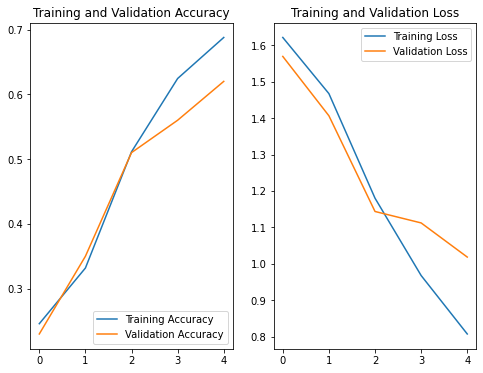

In [ ]:
# Execute the model
curr_dt_time = datetime.datetime.now() # datetimestamp to be appended to model save file

# Reset the Generators to be used by CNN+RNN model
train_generator = generator2(train_path, train_doc, batch_size, img_idx, img_h, img_w)
val_generator = generator2(val_path, val_doc, batch_size, img_idx, img_h, img_w)

# Compile the model and print summary
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
print(model_compile(model, optimiser))

# Train the model
hist = model_train(model, 'basic_cnn_lstm', train_generator, steps_per_epoch, num_epochs, val_generator, validation_steps, curr_dt_time)

# Visualise the model performance
model_plot(hist, num_epochs)

#### **Observations:**
Training accuracy reached maximum (1.0), but overfitting occurred from initial epochs itself.

#### 3.3.5 CNN-LSTM Transfer Model

Use pre-trained ResNet50 as the CNN feature extractor for the basic CNN-LSTM model. Though ResNet50 is heavier than MobileNetV2, it's being used here to observe the performance of feature extraction

In [46]:
from tensorflow.keras.applications import ResNet50

num_classes = 5       # Number of output classes for classification

# Load pre-trained ResNet50 as the CNN feature extractor
# We set `include_top=False` to exclude the dense layers, as we only need feature maps
cnn_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
cnn_base.trainable = False  # Freeze the base model to retain pre-trained features

# Add Global Average Pooling to reduce dimensions of the feature maps from ResNet50
cnn_model = Sequential([
    cnn_base,
    GlobalAveragePooling2D()  # Converts the 3D output of ResNet to a 1D feature vector
])

# Define the full model
model = Sequential()

# Add a TimeDistributed wrapper to process each frame independently
model.add(TimeDistributed(cnn_model, input_shape=(frames_cnt, img_h, img_w, 3)))

# Add LSTM layer for temporal processing
model.add(LSTM(128, return_sequences=False))  # Output from the final LSTM unit will be used for classification

# Add Dense layer for classification
model.add(Dense(num_classes, activation='softmax'))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 15, 2048)         23587712  
 tributed)                                                       
                                                                 
 lstm_3 (LSTM)               (None, 128)               1114624   
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 24,702,981
Trainable params: 1,115,269
Non-trainable params: 23,587,712
_________________________________________________________________
None

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 1.6244 - categorical_accuracy: 0.2081
Source path = /home/datasets/Project_data/val ; batch 

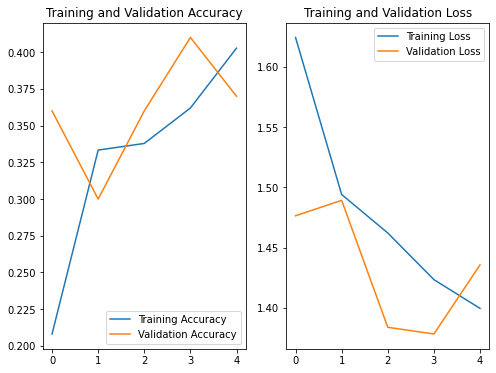

In [47]:
# Execute the model
curr_dt_time = datetime.datetime.now() # datetimestamp to be appended to model save file

# Reset the Generators to be used by CNN+RNN model
train_generator = generator2(train_path, train_doc, batch_size, img_idx, img_h, img_w)
val_generator = generator2(val_path, val_doc, batch_size, img_idx, img_h, img_w)

# Compile the model and print summary
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
print(model_compile(model, optimiser))

# Train the model
hist = model_train(model, 'basic_cnn_lstm_trans', train_generator, steps_per_epoch, num_epochs, val_generator, validation_steps, curr_dt_time)

# Visualise the model performance
model_plot(hist, num_epochs)

#### **Observations:**
There was severe underfitting with training accuracy reaching only a max of 0.58. ResNet50 didn’t go well with LSTM gates. Let's check standard LSTM model with regularisers.

#### 3.3.6 CNN-LSTM Model with Regularisation

Add Drop-outs and L2 Regularisers to each layer of basic CNN-LSTM model

In [48]:
from tensorflow.keras.regularizers import l2

num_classes = 5        # Number of output classes for classification

# Define the CNN feature extractor model with regularization
cnn = Sequential()

# CNN Layers with Dropout and L2 Regularization
cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_h, img_w, 3), kernel_regularizer=l2(0.001)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))  # Dropout after pooling to prevent overfitting

cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(Dropout(0.5))  # Dropout in dense layer

# Define the full model
model = Sequential()

# Add a TimeDistributed wrapper around the CNN model
model.add(TimeDistributed(cnn, input_shape=(frames_cnt, img_h, img_w, 3)))

# LSTM Layer with Dropout for Temporal Dependency
model.add(LSTM(128, return_sequences=False, dropout=0.5, recurrent_dropout=0.5))  # Dropout for LSTM layer

# Dense Layer for Classification
model.add(Dense(num_classes, activation='softmax'))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 15, 256)          2190656   
 tributed)                                                       
                                                                 
 lstm_4 (LSTM)               (None, 128)               197120    
                                                                 
 dense_11 (Dense)            (None, 5)                 645       
                                                                 
Total params: 2,388,421
Trainable params: 2,388,421
Non-trainable params: 0
_________________________________________________________________
None

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 2.0994 - categorical_accuracy: 0.2127
Source path = /home/datasets/Project_data/val ; batch size = 32


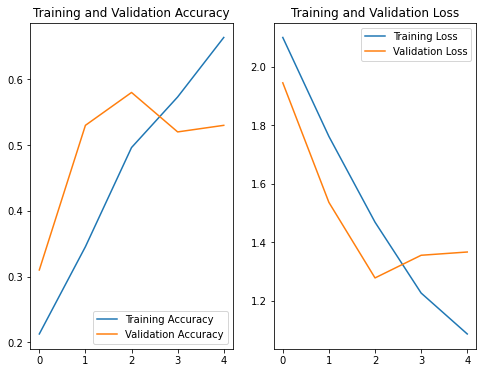

In [49]:
# Execute the model
curr_dt_time = datetime.datetime.now() # datetimestamp to be appended to model save file

# Reset the Generators to be used by CNN+RNN model
train_generator = generator2(train_path, train_doc, batch_size, img_idx, img_h, img_w)
val_generator = generator2(val_path, val_doc, batch_size, img_idx, img_h, img_w)

# Compile the model and print summary
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
print(model_compile(model, optimiser))

# Train the model
hist = model_train(model, 'cnn_lstm_reg', train_generator, steps_per_epoch, num_epochs, val_generator, validation_steps, curr_dt_time)

# Visualise the model performance
model_plot(hist, num_epochs)

#### **Observations:**
Underfitting issue was addressed. But the model still overfits at higher accuracies.

We would try now with higher complexities of Conv2D model with varying image size, batch size and regularization parameters to improve accuracy and reduce overfitting.

#### 3.3.7 Multi-Layer CNN-GRU Model

Add additional layers to CNN-RNN base model with bi-directional GRU to increase accuracy of training and validation further

In [15]:
# Define the 5-Conv2D layer CNN-RNN model

# Reset the image size as (img_h, img_w)
img_h, img_w = 128, 128
input_shape = (img_h, img_w, 3)

cnn = Sequential()
# layer 1: input, with 32 convolutions, maxpooling and batch normalisation
cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

# layer 2: with 64 convolutions, maxpooling and batch normalisation
cnn.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

# layer 3: with 128 convolutions, maxpooling and batch normalisation
cnn.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

# layer 4: with 128 convolutions, maxpooling and batch normalisation
cnn.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

# layer 5: with 128 convolutions, maxpooling and batch normalisation
cnn.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())

# Layer 6: Dense layer with 256 neurons & drop-outs
cnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(Dropout(0.5))

# Layer 7: Dense layer with 256 neurons
cnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))

input_shape = (frames_cnt, img_h, img_w, 3)

model = Sequential()

# Layer 8: Bidirectional GRU layer with drop-outs
model.add(TimeDistributed(cnn, input_shape=input_shape))
model.add(Bidirectional(GRU(32)))
model.add(Dropout(.2))

# Layer 9: with softmax as the last output layer
model.add(Dense(5, activation='softmax'))

2024-11-11 16:16:00.012938: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-11 16:16:00.013005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 256)          980672    
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               55680     
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1,036,677
Trainable params: 1,035,717
Non-trainable params: 960
_________________________________________________________________
None

Source path = /home/datasets/Project

2024-11-11 16:16:21.984204: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 2.7870 - categorical_accuracy: 0.3077
Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 3.29493, saving model to model_cnn_rnn_2_2024-11-1116_16_14.799353/model-00001-2.78697-0.30769-3.29493-0.16000.h5
21/21 [==============================] - 70s 3s/step - loss: 2.7870 - categorical_accuracy: 0.3077 - val_loss: 3.2949 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 2.4879 - categorical_accuracy: 0.3424
Epoch 00002: val_loss did not improve from 3.29493
21/21 [==============================] - 52s 3s/step - loss: 2.4879 - categorical_accuracy: 0.3424 - val_loss: 3.2953 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 2.3111 - categorical_accuracy: 0.4193
Epoch 00003: val_loss did not improve from 3.29493
21/21 [==============================

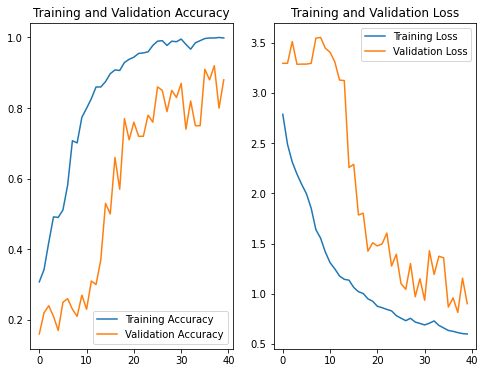

In [16]:
# Execute the model
curr_dt_time = datetime.datetime.now() # datetimestamp to be appended to model save file
num_epochs = 40

# Reset the Generators to be used by CNN+RNN model
train_generator = generator2(train_path, train_doc, batch_size, img_idx, img_h, img_w)
val_generator = generator2(val_path, val_doc, batch_size, img_idx, img_h, img_w)

# Compile the model and print summary
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
print(model_compile(model, optimiser))

# Train the model
hist = model_train(model, 'cnn_rnn_2', train_generator, steps_per_epoch, num_epochs, val_generator, validation_steps, curr_dt_time)

# Visualise the model performance
model_plot(hist, num_epochs)

In [ ]:
# Visualise any specific model history from stored data
# import pandas as pd

# log = pd.DataFrame
# log.history = pd.read_csv('model_cnn_rnn_2_2024-11-0902_38_41.921017/training.log') # Provide the history csv file name with path here

# # Visualise the model performance
# model_plot(log, 50)

#### **Observations:**
The model performance improved well with Val accuracy improved to 0.90 with little gap between training and validation accuracies indicating less overfitting. Though the trainable parameters increased to 1M+, but this is still reasonable for a video analysis model.

This is our best model.

## 4. Conclusion

In conclusion, after experimenting with Conv3D and CNN+RNN based models, we successfully finalised a CNN-RNN model for gesture recognition, achieving a strong performance with a **training accuracy of 1.0 and a validation accuracy of 0.9**. The model architecture utilized five Conv2D layers for feature extraction from video frames, followed by a GRU layer with 32 units to capture temporal dependencies across frames. 

To mitigate overfitting and enhance model generalization, we applied dropout, batch normalization, and kernel regularization within each Conv2D layer. The input images were resized to 128x128 resolution, and a batch size of 32 was used for efficient training. This setup allowed the model to effectively recognize gestures, making it suitable for real-time gesture-controlled applications, such as operating a TV. 

Overall, the model demonstrates both high accuracy and robustness, providing a reliable solution for gesture recognition in video sequences.